In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [198]:
data = pd.read_csv("a2a_train_final.tsv", sep="\t") 
data_test=pd.read_csv("a2a_test_final.tsv", sep="\t")
data_test.columns=["Class", "Comment"]                    
#data = pd.read_csv("a2a_train_round1.tsv", sep="\t") 
data.columns = ["Class", "Comment"]

In [199]:
# the actual classification algorithm
from sklearn.svm import LinearSVC

# for converting training and test datasets into matrices
# TfidfVectorizer does this specifically for documents
from sklearn.feature_extraction.text import TfidfVectorizer

# for bundling the vectorizer and the classifier as a single "package"
from sklearn.pipeline import make_pipeline

# for splitting the dataset into training and test sets 
from sklearn.model_selection import train_test_split

# for evaluating the quality of the classifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report, confusion_matrix ,f1_score

import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [204]:
data_test

,Class,Comment
0,0,I had to trigger Article 50. It would have bee...
1,0,Uh we want to leave the EU but we want to keep...
2,1,#DeathtotheEU oh wow I really hate the #EU Wha...
3,1,#IVotedLeave and I hope you did too! #EUref le...
4,1,#IVotedLeave for the love of democracy and to ...
...,...,...
1154,0,when will the brits start to realise that 350....
1155,1,yea it's really good decision for Britain to m...
1156,0,роverty and dооm awaits the country
1157,1,“The humiliation of having a pink European Uni...


In [201]:
from collections import Counter
test = Counter(" ".join(data["Comment"]).split())
len(test.keys())

test = Counter(" ".join(data_test["Comment"]).split())
len(test.keys())

6096

# 1. Text data preprocessing

# 1.1 Drop inconsistent annotation 

Drop those comments with inconsistent annotation. 81.6% comments are filtered out after this step, containing 50.4% pro-brexit(1) and 49.6% anti-brexit(0).

In [6]:
#def find_majority(k):
#    myMap = {}
#    maximum = ( '', 0 ) # (occurring element, occurrences)
#    for n in k:
#        if n in myMap: myMap[n] += 1
#        else: myMap[n] = 1
#
#        # Keep track of maximum on the go
#        if myMap[n] > maximum[1]: maximum = (n,myMap[n])
#
#    return maximum

for index, row in data.iterrows():
    arr = row["Class"].split("/")
    if(len(set(arr)) > 1):
        #print(arr)
        data = data.drop(index, axis=0)
    else:
        data.loc[index]["Class"]=arr[0]
data=data.reset_index(drop=True)

#for index, row in data.iterrows():
#    arr = row["Class"].split("/")
#    #if(len(set(arr)) > 1):
#    if(arr.count('1') > arr.count('0')):
#        #print(arr)
#        data.set_value(index, "Class", 1)
#    elif(arr.count('0') > arr.count('1')):
#        data.set_value(index, "Class", 0)
#    else:
#        data.set_value(index, "Class", 1)
#        #data = data.drop(index, axis=0)
#data = data.reset_index()
data

,Class,Comment
0,0,Being a member of the European Union is a bit ...
1,0,Brexit is bad. Immigrants make Britain great. ...
2,0,Britain is basically Pompeii if the Pompeii ha...
3,1,Britain's exit is a huge blow to the dream of ...
4,1,"Death to the EU, Death to the EU!"
...,...,...
10999,1,“we have made our choice”
11000,1,”Fake news! UK will prosper as soon as Bojo si...
11001,1,🇬🇧 Hard Brexit all the way 🇬🇧
11002,0,"😆 it's funny, when the brits sees the raise in..."


In [7]:
from collections import Counter
cnt=Counter(data["Class"])
print("pro-brexit = %0.4f and anti-brexit=%0.4f" %(cnt['0']/(cnt['0']+cnt['1']), cnt['1']/(cnt['0']+cnt['1'])))


#test = Counter(" ".join(data[data["Class"] == '1']["Comment"]).split()).most_common()[:-1000-1:-1]
#test2 = Counter(" ".join(data[data["Class"] == '0']["Comment"]).split()).most_common()[:-1000-1:-1]
#test = Counter(" ".join(data["Comment"]).split()).most_common()[:-1000-1:-1]
test = Counter(" ".join(data["Comment"]).split())

pro-brexit = 0.4825 and anti-brexit=0.5175


In [8]:
len(test.keys())

29687

# 1.2 Noise Removal

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    #print(soup.get_text())
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = replace_contractions(text)
    text = strip_html(text)
    return text
def Noise_Removal():
    for index, row in data.iterrows():
        data.loc[index]['Comment'] = denoise_text(data['Comment'][index])


# 1.3 Lowercasing

In [22]:
data['Comment']=data['Comment'].str.lower()

In [23]:
test = Counter(" ".join(data["Comment"]).split())
len(test.keys())

8095

# 1.4 Tokenization

Tokenization is a step which splits longer strings of text into smaller pieces, or tokens. 

In [12]:
def Tokenization():
    for index, row in data.iterrows():
        data.loc[index]['Comment'] = " ".join(nltk.word_tokenize(data['Comment'][index]))

# 1.5 Normalization

# 1.5.1 stemming and Lemmatization

In [13]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

# 1.5.2 Remove Punctuation

In [14]:
 def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#print(index)
#data['Comment'][13514].split()
#" ".join(remove_punctuation(data['Comment'][13514].split()))


# 1.5.3 replace_numbers
Replace all interger occurrences in list of tokenized words with textual representation

In [15]:
import inflect
def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words



# 1.5.4 remove_non_ascii

In [16]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


# 1.5.5 Remove stop words

In [17]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words



In [18]:
def Normalization():
    for index, row in data.iterrows():
        data.loc[index]['Comment'] = " ".join(stem_words(data['Comment'][index].split()))
        data.loc[index]['Comment'] = " ".join(lemmatize_verbs(data['Comment'][index].split()))
        data.loc[index]['Comment'] = " ".join(remove_punctuation(data['Comment'][index].split()))
        data.loc[index]['Comment'] = " ".join(replace_numbers(data['Comment'][index].split()))
        data.loc[index]['Comment'] = " ".join(remove_non_ascii(data['Comment'][index].split()))
        data.loc[index]['Comment'] = " ".join(remove_stopwords(data['Comment'][index].split()))

# 1.6 Process

# 1.6.1 Lowercasing

In [205]:
data['Comment']=data['Comment'].str.lower()
data_test['Comment'] = data_test['Comment'].str.lower()

In [206]:
test = Counter(" ".join(data["Comment"]).split())
len(test.keys())
data_test

,Class,Comment
0,0,i had to trigger article 50. it would have bee...
1,0,uh we want to leave the eu but we want to keep...
2,1,#deathtotheeu oh wow i really hate the #eu wha...
3,1,#ivotedleave and i hope you did too! #euref le...
4,1,#ivotedleave for the love of democracy and to ...
...,...,...
1154,0,when will the brits start to realise that 350....
1155,1,yea it's really good decision for britain to m...
1156,0,роverty and dооm awaits the country
1157,1,“the humiliation of having a pink european uni...


# 1.6.2 Loop

Noise Removal -> Tokenization -> Normalization until it is converged (10 times)

In [207]:
n=0
words_dist=[]
N=[]
while (n<10):
    N.append(n)
    Noise_Removal()
    Tokenization()
    Normalization()
    test = Counter(" ".join(data["Comment"]).split())
    words_dist.append(len(test.keys()))
    n+=1

KeyboardInterrupt: 

[8819, 8219, 8122, 8100, 8097, 8097, 8096, 8096, 8096, 8095]


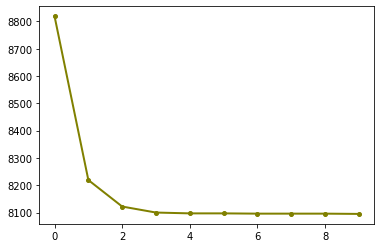

In [24]:
print(words_dist)
plt.plot(N,words_dist,color='olive',marker='o', markerfacecolor='olive', markersize=4, linewidth=2,label='loops vs distinct words')

# final test set

In [209]:
n=0
words_dist_test=[]
N_test=[]
while (n<10):
    N_test.append(n)
    Noise_Removal()
    Tokenization()
    Normalization()
    test = Counter(" ".join(data_test["Comment"]).split())
    words_dist_test.append(len(test.keys()))
    n+=1

In [266]:
print(words_dist_test)

[5474, 5474, 5474, 5474, 5474, 5474, 5474, 5474, 5474, 5474]


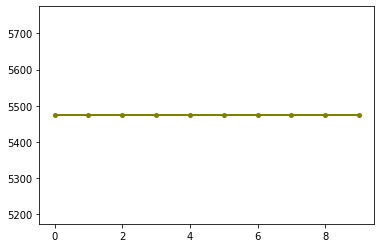

In [267]:
plt.plot(N_test,words_dist_test,color='olive',marker='o', markerfacecolor='olive', markersize=4, linewidth=2,label='loops vs distinct words')

# 1.7 Deemphasizing common words

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
Y=data['Class']
X=data['Comment']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [270]:
Xfinal=data_test['Comment']
Yfinal=data_test['Class']


# 1.8 Create trainning and test sets


In [32]:
Xtrain1, Xtest1, Ytrain1, Ytest1 = train_test_split(X, Y, test_size=0.2, random_state=0)

In [27]:
Xtrain.shape

(8803, 8077)

In [28]:
Xtrain1

4479     vot leav escap unit stat europ recess damn eco...
8590     thi first piec video tap real ang brit memb eu...
5366                                            leav simpl
4548     britain leav eu scotland ano referund leav bri...
5925                                      deal suit hat eu
                               ...                        
4859     gre eu lik hav escap al burn build watch selfd...
3264     hap uk decid leav eu without plan tak year pre...
9845     com lik brexit part liberalm london bubbl vot ...
10799    peopl hav spok govt peopl peopl un elect forei...
2732     fuck bor johnson fuck trump fuck brexit fuck k...
Name: Comment, Length: 8803, dtype: object

# 2 Training the classfiers 

# 2.1 the baseline classifier

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

pipeline = make_pipeline(
      TfidfVectorizer(),
      DummyClassifier(strategy='most_frequent')
    )
clf=pipeline.fit(Xtrain,Ytrain)


cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()

0.5182324092715915

In [41]:
clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)
accuracy_score(Ytest, Yguess)

0.5147660154475239

# Evaluate the Models using confusion matrix


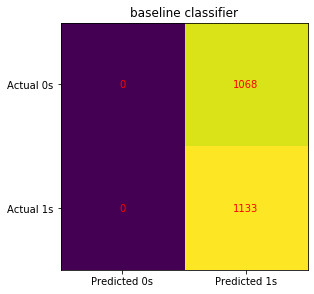

In [42]:
cm = confusion_matrix(Ytest, Yguess)
fig= plt.figure()
ax = fig.add_subplot(221)
fig.set_size_inches(10, 10)
ax.title.set_text('baseline classifier')
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [43]:
print(classification_report(Ytest, Yguess))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1068
           1       0.51      1.00      0.68      1133

    accuracy                           0.51      2201
   macro avg       0.26      0.50      0.34      2201
weighted avg       0.26      0.51      0.35      2201



C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 2.2 Trying out some different classifiers

# 2.2.1 Linear classifiers

In [ ]:
from sklearn.linear_model import Perceptron
pipeline = make_pipeline(
      TfidfVectorizer(),
      Perceptron(random_state=10)
    )
 
lcp=pipeline.fit(Xtrain,Ytrain)
cross_val_score(lcp, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()

# Perceptron

In [44]:
from sklearn.linear_model import Perceptron
pipeline = make_pipeline(
      TfidfVectorizer(),
      Perceptron(random_state=10)
    )
 
lcp=pipeline.fit(Xtrain,Ytrain)
cross_val_score(lcp, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()

0.7136208120386144

In [47]:
lcp.fit(Xtrain, Ytrain)
Yguess_lcp = lcp.predict(Xtest)
Ypredprob_lcp = lcp.fit(Xtrain, Ytrain).decision_function(Xtest)
Ypredprob_lcp = (Ypredprob_lcp - Ypredprob_lcp.min()) / (Ypredprob_lcp.max() - Ypredprob_lcp.min())
Ytest_n=Ytest.astype(int)
fpr_lcp, tpr_lcp, threshold_lcp = roc_curve(Ytest_n, Ypredprob_lcp)
roc_auc_lcp = auc(fpr_lcp, tpr_lcp)
optimal_idx_lcp = np.argmax(tpr_lcp - fpr_lcp)
optimal_threshold_lcp = threshold_lcp[optimal_idx_lcp]
print('The optimal threshold is %0.2f' %optimal_threshold_lcp)
print ("Accuracy : %.4f" % accuracy_score(Ytest, Yguess_lcp))
print ("AUC Score (Train): %f" % roc_auc_score(Ytest, Ypredprob_lcp))

The optimal threshold is 0.49
Accuracy : 0.7133
AUC Score (Train): 0.788699


# LogisticRegression

In [49]:
from sklearn.linear_model import LogisticRegression
lclr = make_pipeline(
      TfidfVectorizer(),
      LogisticRegression(multi_class='auto',solver='newton-cg', max_iter=5000,random_state=10)
    )

lclr=lclr.fit(Xtrain,Ytrain)
cross_val_score(lclr, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()

0.7723512596148882

In [51]:
lclr.fit(Xtrain, Ytrain)
Yguess_lclr=lclr.predict(Xtest)
Ypredprob_lclr = lclr.fit(Xtrain, Ytrain).decision_function(Xtest)
Ypredprob_lclr = (Ypredprob_lclr - Ypredprob_lclr.min()) / (Ypredprob_lclr.max() - Ypredprob_lclr.min())
Ytest_n=Ytest.astype(int)
fpr_lclr, tpr_lclr, threshold_lclr = roc_curve(Ytest_n, Ypredprob_lclr)
roc_auc_lclr = auc(fpr_lclr, tpr_lclr)
optimal_idx_lclr = np.argmax(tpr_lclr - fpr_lclr)
optimal_threshold_lclr = threshold_lcp[optimal_idx_lclr]
print('The optimal threshold is %0.2f' %optimal_threshold_lclr)
print ("Accuracy : %.4f" % accuracy_score(Ytest, Yguess_lclr))
print ("AUC Score (Train): %f" % roc_auc_score(Ytest, Ypredprob_lclr))

The optimal threshold is 0.55
Accuracy : 0.7706
AUC Score (Train): 0.852491


# LinearSVC

In [52]:
from sklearn.svm import LinearSVC

slSVC = make_pipeline(
      TfidfVectorizer(),
      LinearSVC(max_iter=10000, random_state=10)
    )
slSVC=slSVC.fit(Xtrain,Ytrain)
cross_val_score(slSVC, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()

0.7639459114139693

In [53]:
slSVC.fit(Xtrain, Ytrain)
Yguess_slSVC=slSVC.predict(Xtest)
Ypredprob_slSVC = slSVC.fit(Xtrain, Ytrain).decision_function(Xtest)
Ypredprob_slSVC = (Ypredprob_slSVC - Ypredprob_slSVC.min()) / (Ypredprob_slSVC.max() - Ypredprob_slSVC.min())
Ytest_n=Ytest.astype(int)
fpr_slSVC, tpr_slSVC, threshold_slSVC = roc_curve(Ytest_n, Ypredprob_slSVC)
roc_auc_slSVC = auc(fpr_slSVC, tpr_slSVC)
optimal_idx_slSVC = np.argmax(tpr_slSVC - fpr_slSVC)
optimal_threshold_slSVC = threshold_lcp[optimal_idx_slSVC]
print('The optimal threshold is %0.2f' %optimal_threshold_slSVC)
print ("Accuracy : %.4f" % accuracy_score(Ytest, Yguess_slSVC))
print ("AUC Score (Train): %f" % roc_auc_score(Ytest, Ypredprob_slSVC))

The optimal threshold is 0.54
Accuracy : 0.7651
AUC Score (Train): 0.847337


# Evaluate the Models using confusion matrix

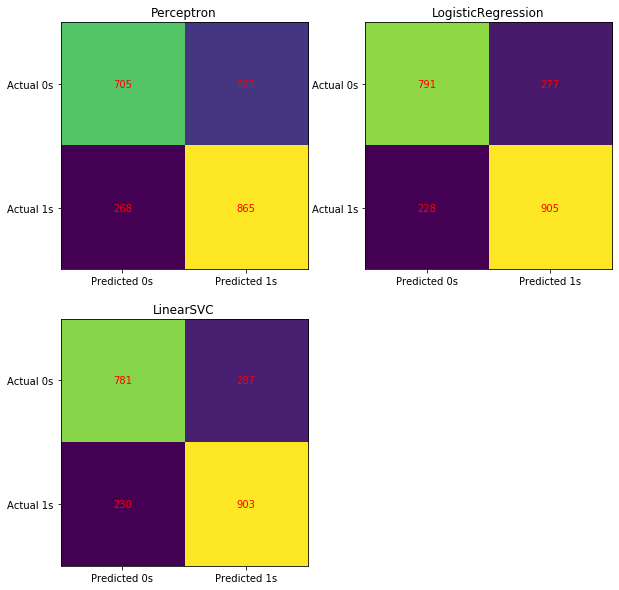

In [54]:
lcp_cm=confusion_matrix(Ytest, Yguess_lcp)
lclr_cm = confusion_matrix(Ytest, Yguess_lclr)
slSVC_cm = confusion_matrix(Ytest, Yguess_slSVC)

fig= plt.figure()
fig.set_size_inches(10, 10)
ax1 = fig.add_subplot(221)
ax1.title.set_text('Perceptron')
ax1.imshow(lcp_cm)
ax1.grid(False)
ax1.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax1.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax1.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax1.text(j, i, lcp_cm[i, j], ha='center', va='center', color='red')
ax2 = fig.add_subplot(222)
ax2.title.set_text('LogisticRegression')
ax2.imshow(lclr_cm)
ax2.grid(False)
ax2.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax2.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax2.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax2.text(j, i, lclr_cm[i, j], ha='center', va='center', color='red')
ax3 = fig.add_subplot(223)
ax3.title.set_text('LinearSVC')
ax3.imshow(slSVC_cm)
ax3.grid(False)
ax3.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax3.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax3.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax3.text(j, i, slSVC_cm[i, j], ha='center', va='center', color='red')        
        
plt.show()

In [55]:
print(classification_report(Ytest, Yguess_lcp))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1068
           1       0.70      0.76      0.73      1133

    accuracy                           0.71      2201
   macro avg       0.71      0.71      0.71      2201
weighted avg       0.71      0.71      0.71      2201



In [56]:
print(classification_report(Ytest, Yguess_lclr))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1068
           1       0.77      0.80      0.78      1133

    accuracy                           0.77      2201
   macro avg       0.77      0.77      0.77      2201
weighted avg       0.77      0.77      0.77      2201



In [57]:
print(classification_report(Ytest, Yguess_slSVC))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1068
           1       0.76      0.80      0.78      1133

    accuracy                           0.77      2201
   macro avg       0.77      0.76      0.76      2201
weighted avg       0.77      0.77      0.76      2201



# 2.2.2 Tree-based classifiers

# DecisionTreeClassifier

In [59]:
from sklearn import tree
dtc = make_pipeline(
      TfidfVectorizer(),
      tree.DecisionTreeClassifier(random_state=10)
    )
dtc=dtc.fit(Xtrain,Ytrain)
cross_val_score(dtc, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()

0.6588642171286975

In [61]:
Yguess_dtc = dtc.predict(Xtest)
Ypredprob_dtc = dtc.predict_proba(Xtest)[:,1]
Ytest_n=Ytest.astype(int)
fpr_dtc, tpr_dtc, threshold_dtc = roc_curve(Ytest_n, Ypredprob_dtc)
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)
optimal_idx_dtc = np.argmax(tpr_dtc - fpr_dtc)
optimal_threshold_dtc = threshold_dtc[optimal_idx_dtc]
print('The optimal threshold is %0.2f' %optimal_threshold_dtc)
print ("Accuracy : %.4f" % accuracy_score(Ytest, Yguess_dtc))
print ("AUC Score (Train): %f" % roc_auc_score(Ytest, Ypredprob_dtc))

The optimal threshold is 1.00
Accuracy : 0.6724
AUC Score (Train): 0.670445


# RandomForestClassifier

In [62]:
from sklearn.ensemble import RandomForestClassifier
dfc = make_pipeline(
      TfidfVectorizer(),
      RandomForestClassifier(n_estimators=100,random_state=10)
    )
dfc=dfc.fit(Xtrain,Ytrain)
cross_val_score(dfc, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()

0.7600813716380157

In [238]:
Yguess_dfc = dfc.predict(Xtest)
Yguess_dfc_n=Yguess_dfc.astype(int)
Ypredprob_dfc = dfc.predict_proba(Xtest)[:,1]
Ytest_n=Ytest.astype(int)
fpr_dfc, tpr_dfc, threshold_dfc = roc_curve(Ytest_n, Ypredprob_dfc)
roc_auc_dfc = auc(fpr_dfc, tpr_dfc)
optimal_idx_dfc = np.argmax(tpr_dfc - fpr_dfc)
optimal_threshold_dfc = threshold_dfc[optimal_idx_dfc]
print('The optimal threshold is %0.2f' %optimal_threshold_dfc)
print ("Accuracy : %.4f" % accuracy_score(Ytest, Yguess_dfc))
print ("AUC Score (Train): %f" % roc_auc_score(Ytest, Ypredprob_dfc))

dfc

The optimal threshold is 0.56
Accuracy : 0.7628
AUC Score (Train): 0.843416


Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [118]:
print(classification_report(Ytest, Yguess_dfc))


              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1068
           1       0.74      0.82      0.78      1133

    accuracy                           0.76      2201
   macro avg       0.77      0.76      0.76      2201
weighted avg       0.77      0.76      0.76      2201



In [119]:
f1_score(Ytest_n, Yguess_dfc_n)

0.7812238055322716

# GradientBoostingClassifier


In [126]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = make_pipeline(
      TfidfVectorizer(),
      GradientBoostingClassifier(random_state=10)
    )
gbc=gbc.fit(Xtrain,Ytrain)
cross_val_score(gbc, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()
gbc[1]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [120]:
Yguess_gbc = gbc.predict(Xtest)
Yguess_gbc_n=Yguess_gbc.astype(int)
Ypredprob_gbc = gbc.predict_proba(Xtest)[:,1]
Ytest_n=Ytest.astype(int)
fpr_gbc, tpr_gbc, threshold_gbc = roc_curve(Ytest_n, Ypredprob_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
optimal_idx_gbc = np.argmax(tpr_gbc - fpr_gbc)
optimal_threshold_gbc = threshold_gbc[optimal_idx_gbc]
print('The optimal threshold is %0.2f' %optimal_threshold_gbc)
print ("Accuracy : %.4f" % accuracy_score(Ytest, Yguess_gbc))
print ("AUC Score (Train): %f" % roc_auc_score(Ytest, Ypredprob_gbc))

The optimal threshold is 0.52
Accuracy : 0.7229
AUC Score (Train): 0.801467


In [122]:
f1_score(Ytest_n, Yguess_gbc_n)

0.7512234910277326

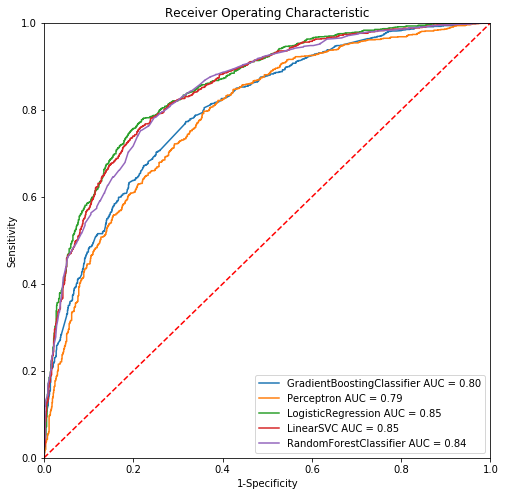

In [68]:
fig=plt.figure()
fig.set_size_inches(8, 8)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gbc, tpr_gbc, label = 'GradientBoostingClassifier AUC = %0.2f' % roc_auc_gbc)
plt.plot(fpr_lcp, tpr_lcp, label = 'Perceptron AUC = %0.2f' % roc_auc_lcp)
plt.plot(fpr_lclr, tpr_lclr, label = 'LogisticRegression AUC = %0.2f' % roc_auc_lclr)
plt.plot(fpr_slSVC, tpr_slSVC, label = 'LinearSVC AUC = %0.2f' % roc_auc_slSVC)
plt.plot(fpr_dfc, tpr_dfc, label = 'RandomForestClassifier AUC = %0.2f' % roc_auc_dfc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Sensitivity')
plt.xlabel('1-Specificity')
plt.show()

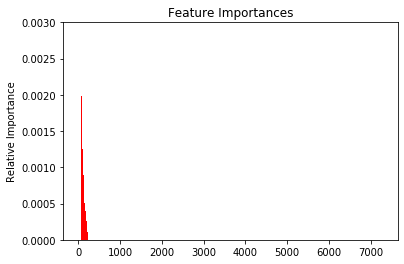

the most important feature is brexit eu


In [99]:
pipeline = make_pipeline(
      TfidfVectorizer(),
      GradientBoostingClassifier(random_state=10)
    )

pip=pipeline.fit(Xtrain,Ytrain)

#print(pip[0].get_feature_names())

names= [name for name in pip[0].get_feature_names()]

importances= [importance for importance in pip[1].feature_importances_]

indices = np.argsort(importances)[::-1]
matrix=[importances[i] for i in indices]
name_matrix=[names[i] for i in indices]
plt.title('Feature Importances')
plt.bar(range(len(indices)), matrix,color="r", align="center")
plt.ylim([0,0.003])
plt.ylabel('Relative Importance')
plt.show()

print("the most important feature is " + name_matrix[0] + " " + name_matrix[1] )
#pip[1].feature_importances_

# Evaluate the Models using confusion matrix


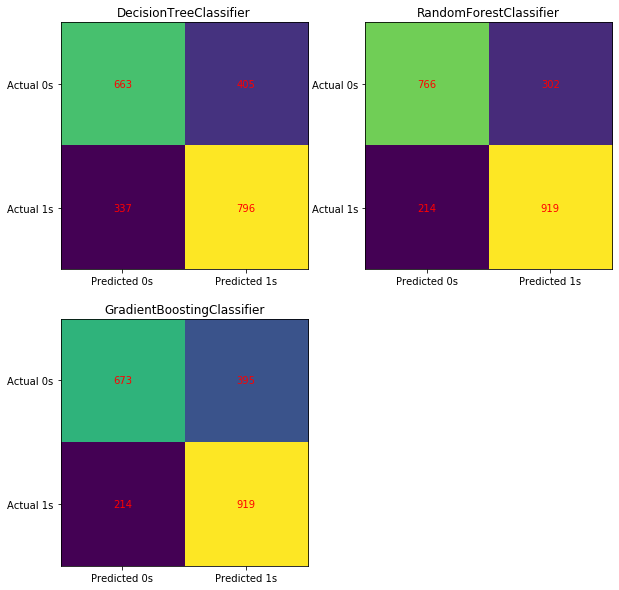

In [227]:
dtc_cm=confusion_matrix(Ytest, Yguess_dtc)
dfc_cm = confusion_matrix(Ytest, Yguess_dfc)
gbc_cm = confusion_matrix(Ytest, Yguess_gbc)

fig= plt.figure()
fig.set_size_inches(10, 10)
ax1 = fig.add_subplot(221)
ax1.title.set_text('DecisionTreeClassifier')
ax1.imshow(dtc_cm)
ax1.grid(False)
ax1.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax1.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax1.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax1.text(j, i, dtc_cm[i, j], ha='center', va='center', color='red')
ax2 = fig.add_subplot(222)
ax2.title.set_text('RandomForestClassifier')
ax2.imshow(dfc_cm)
ax2.grid(False)
ax2.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax2.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax2.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax2.text(j, i, dfc_cm[i, j], ha='center', va='center', color='red')
ax3 = fig.add_subplot(223)
ax3.title.set_text('GradientBoostingClassifier')
ax3.imshow(gbc_cm)
ax3.grid(False)
ax3.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax3.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax3.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax3.text(j, i, gbc_cm[i, j], ha='center', va='center', color='red')        
plt.show()

# Exhaustive search over specified parameter values for an estimator
GradientBoostingClassifier and RandomForestClassifier

# GradientBoostingClassifier 

# n_estimater and learning_rate search

In [163]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(270,300,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, min_samples_split=300,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',iid=False,cv=5)

In [164]:
gsearch1.fit(Xtrain1,Ytrain1)

C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=20,
                                                  min_samples_split=300,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [166]:
N=[]
M=[]
i=[]
c=20
#for n, m,v  in zip(gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['std_test_score'], gsearch1.cv_results_['params']):
 #   N.append(n)
    #M.append(M)
    #i.append(c)
    #c+=20    
   # print(n,m,v)
#gsearch1.best_params_, gsearch1.best_score_

for n, m,v  in zip(gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['std_test_score'], gsearch1.cv_results_['params']):
    print(n,m,v)
    
gsearch1.best_params_, gsearch1.best_score_

0.8361736223596165 0.008333860443370304 {'n_estimators': 270}
0.8365465922319769 0.00817701081322274 {'n_estimators': 275}
0.8368022023293534 0.008786875429722186 {'n_estimators': 280}
0.8365800311842756 0.008546681940070796 {'n_estimators': 285}
0.8365107184129261 0.008477442808513083 {'n_estimators': 290}
0.8362787094777063 0.008312671214524689 {'n_estimators': 295}


({'n_estimators': 280}, 0.8368022023293534)

# max_depth and min_samples_split

In [157]:
param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(100,801,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=280, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10), 
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)

In [158]:
gsearch2.fit(Xtrain1,Ytrain1)

C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=20,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=280,
                                                  n_iter_no_change=None,
      

In [167]:
for n, m, v  in zip(gsearch2.cv_results_['mean_test_score'], gsearch2.cv_results_['std_test_score'], gsearch2.cv_results_['params']):
    print(n,m,v)
gsearch2.best_params_, gsearch2.best_score_

0.8298178203900441 0.012882322443907971 {'max_depth': 3, 'min_samples_split': 100}
0.8299957429760534 0.012964756438274787 {'max_depth': 3, 'min_samples_split': 300}
0.8295867884773636 0.01255053748924744 {'max_depth': 3, 'min_samples_split': 500}
0.8293533761619937 0.013038193856472046 {'max_depth': 3, 'min_samples_split': 700}
0.8352553592102095 0.011336817164773822 {'max_depth': 5, 'min_samples_split': 100}
0.8362334041202762 0.010536505019159917 {'max_depth': 5, 'min_samples_split': 300}
0.8357961576225827 0.01109195425453496 {'max_depth': 5, 'min_samples_split': 500}
0.8362108715883865 0.012060580789129083 {'max_depth': 5, 'min_samples_split': 700}
0.8355111715819685 0.010353013344742663 {'max_depth': 7, 'min_samples_split': 100}
0.836928007320666 0.009835610407832332 {'max_depth': 7, 'min_samples_split': 300}
0.836162145230319 0.010530293970798956 {'max_depth': 7, 'min_samples_split': 500}
0.8359130147750543 0.0107207731470157 {'max_depth': 7, 'min_samples_split': 700}
0.83526291

({'max_depth': 11, 'min_samples_split': 500}, 0.8370139525276201)

In [168]:
param_test2 = {'max_depth':range(14,25,2), 'min_samples_split':range(100,801,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=280, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10), 
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)

In [169]:
gsearch2.fit(Xtrain1,Ytrain1)

C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=20,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=280,
                                                  n_iter_no_change=None,
      

In [170]:
for n, m, v  in zip(gsearch2.cv_results_['mean_test_score'], gsearch2.cv_results_['std_test_score'], gsearch2.cv_results_['params']):
    print(n,m,v)
gsearch2.best_params_, gsearch2.best_score_

0.8329417094282171 0.01025304242949655 {'max_depth': 14, 'min_samples_split': 100}
0.8328678661151526 0.010998657482634261 {'max_depth': 14, 'min_samples_split': 300}
0.8327011082482034 0.010534673301630972 {'max_depth': 14, 'min_samples_split': 500}
0.8341431516024592 0.010547766169775732 {'max_depth': 14, 'min_samples_split': 700}
0.833563330399457 0.010517713634961548 {'max_depth': 16, 'min_samples_split': 100}
0.8329096366183212 0.009767742300450796 {'max_depth': 16, 'min_samples_split': 300}
0.8317070513011183 0.010572784196555007 {'max_depth': 16, 'min_samples_split': 500}
0.8321613539945766 0.010465025280305252 {'max_depth': 16, 'min_samples_split': 700}
0.8311846784298961 0.009377387574345765 {'max_depth': 18, 'min_samples_split': 100}
0.8325746724483162 0.008609103359964248 {'max_depth': 18, 'min_samples_split': 300}
0.833741739502482 0.00916956526965414 {'max_depth': 18, 'min_samples_split': 500}
0.8338885157778704 0.011003579707231387 {'max_depth': 18, 'min_samples_split': 7

({'max_depth': 14, 'min_samples_split': 700}, 0.8341431516024592)

In [173]:
param_test2 = {'max_depth':range(11,101,20), 'min_samples_split':range(400,1000,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=280, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10), 
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)

In [174]:
gsearch2.fit(Xtrain1,Ytrain1)

C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=20,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=280,
                                                  n_iter_no_change=None,
      

In [175]:
for n, m, v  in zip(gsearch2.cv_results_['mean_test_score'], gsearch2.cv_results_['std_test_score'], gsearch2.cv_results_['params']):
    print(n,m,v)
gsearch2.best_params_, gsearch2.best_score_

0.8357211607872632 0.008693794573073732 {'max_depth': 11, 'min_samples_split': 400}
0.8363423430592054 0.010659349164060491 {'max_depth': 11, 'min_samples_split': 600}
0.8347008751948799 0.009766959144593843 {'max_depth': 11, 'min_samples_split': 800}
0.8277421711793908 0.01042133534189667 {'max_depth': 31, 'min_samples_split': 400}
0.8278314336102198 0.010453991773522202 {'max_depth': 31, 'min_samples_split': 600}
0.8269388313019436 0.009692846118510672 {'max_depth': 31, 'min_samples_split': 800}
0.8250285928754316 0.00860520112879452 {'max_depth': 51, 'min_samples_split': 400}
0.8234664218477338 0.009316493062686539 {'max_depth': 51, 'min_samples_split': 600}
0.8246798097251764 0.009364535373539234 {'max_depth': 51, 'min_samples_split': 800}
0.8255130254064449 0.007183844096235977 {'max_depth': 71, 'min_samples_split': 400}
0.8264332390084375 0.007616435877475918 {'max_depth': 71, 'min_samples_split': 600}
0.8223756499356348 0.008138934666489671 {'max_depth': 71, 'min_samples_split':

({'max_depth': 11, 'min_samples_split': 600}, 0.8363423430592054)

In [179]:
param_test2 = {'max_depth':range(10,14,1), 'min_samples_split':range(400,800,100)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=280, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10), 
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)

In [181]:
gsearch2.fit(Xtrain1,Ytrain1)

C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=20,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=280,
                                                  n_iter_no_change=None,
      

In [182]:
for n, m, v  in zip(gsearch2.cv_results_['mean_test_score'], gsearch2.cv_results_['std_test_score'], gsearch2.cv_results_['params']):
    print(n,m,v)
gsearch2.best_params_, gsearch2.best_score_

0.8361798123743593 0.008721760743405327 {'max_depth': 10, 'min_samples_split': 400}
0.8334824118673568 0.010433864180031364 {'max_depth': 10, 'min_samples_split': 500}
0.8352967479269637 0.010135133515818363 {'max_depth': 10, 'min_samples_split': 600}
0.8352088641675557 0.010953753693713132 {'max_depth': 10, 'min_samples_split': 700}
0.8357211607872632 0.008693794573073732 {'max_depth': 11, 'min_samples_split': 400}
0.8370139525276201 0.010180716451877776 {'max_depth': 11, 'min_samples_split': 500}
0.8363423430592054 0.010659349164060491 {'max_depth': 11, 'min_samples_split': 600}
0.835340954125613 0.009680234230251893 {'max_depth': 11, 'min_samples_split': 700}
0.833419269197238 0.012195237839148759 {'max_depth': 12, 'min_samples_split': 400}
0.8350047080994948 0.010825752504304656 {'max_depth': 12, 'min_samples_split': 500}
0.834805671935775 0.009845194000153672 {'max_depth': 12, 'min_samples_split': 600}
0.8347695836579601 0.01010771633808595 {'max_depth': 12, 'min_samples_split': 7

({'max_depth': 11, 'min_samples_split': 500}, 0.8370139525276201)

In [188]:
gbc_test=GradientBoostingClassifier(learning_rate=0.2, n_estimators=280, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10,max_depth=11,min_samples_split=500)
gbc_test.fit(Xtrain1,Ytrain1)

gbc_guess=gbc_test.predict(Xtest1)
gbc_guess_n=gbc_guess.astype(int)
Ypredprob_gbc_test = gbc_test.predict_proba(Xtest1)[:,1]
Ytest1_n=Ytest1.astype(int)
fpr_gbc_test, tpr_gbc_test, threshold_gbc_test = roc_curve(Ytest1_n, Ypredprob_gbc_test)
roc_auc_gbc_test = auc(fpr_gbc_test, tpr_gbc_test)
optimal_idx_gbc_test = np.argmax(tpr_gbc_test - fpr_gbc_test)
optimal_threshold_gbc_test = threshold_gbc_test[optimal_idx_gbc_test]
print('The optimal threshold is %0.2f' %optimal_threshold_gbc_test)
print ("Accuracy : %.4f" % accuracy_score(Ytest1, gbc_guess))
print ("AUC Score (Train): %f" % roc_auc_score(Ytest1, Ypredprob_gbc_test))


The optimal threshold is 0.49
Accuracy : 0.7669
AUC Score (Train): 0.842174


# min_samples_split and min_samples_leaf

In [211]:
param_test3 = {'min_samples_split':range(300,1700,200), 'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=280,max_depth=11,
                                     max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(Xtrain1,Ytrain1)

KeyboardInterrupt: 

In [210]:
for n, m, v  in zip(gsearch3.cv_results_['mean_test_score'], gsearch3.cv_results_['std_test_score'], gsearch3.cv_results_['params']):
    print(n,m,v)
gsearch3.best_params_, gsearch3.best_score_

0.8029413465635425 0.008025644138416879 {'min_samples_leaf': 60, 'min_samples_split': 300}
0.802473411133619 0.008582747146131749 {'min_samples_leaf': 60, 'min_samples_split': 500}
0.8029016687572179 0.007235132491877502 {'min_samples_leaf': 60, 'min_samples_split': 700}
0.8024327889935021 0.008205770073486591 {'min_samples_leaf': 60, 'min_samples_split': 900}
0.8029870596421944 0.007388140484305886 {'min_samples_leaf': 60, 'min_samples_split': 1100}
0.8026328476374036 0.008564690146895254 {'min_samples_leaf': 60, 'min_samples_split': 1300}
0.8017490317848794 0.00900892888492466 {'min_samples_leaf': 60, 'min_samples_split': 1500}
0.7981112193809183 0.009617168603045682 {'min_samples_leaf': 70, 'min_samples_split': 300}
0.7986058675632031 0.009679396080368654 {'min_samples_leaf': 70, 'min_samples_split': 500}
0.7978975617313815 0.009889261883505682 {'min_samples_leaf': 70, 'min_samples_split': 700}
0.7985373558553187 0.008609116221990652 {'min_samples_leaf': 70, 'min_samples_split': 900

({'min_samples_leaf': 60, 'min_samples_split': 1100}, 0.8029870596421944)

In [193]:
gb = GradientBoostingClassifier(learning_rate=0.1, subsample=1, n_estimators=280,max_depth=50, min_samples_split=500, min_samples_leaf=1,max_features='sqrt' , random_state=10)
gb.fit(Xtrain1, Ytrain1)
Y_pred = gb.predict(Xtest1)
accuracy_score(Y_pred, Ytest1)

0.7705588368923216

# RandomForestClassifier

# n_estimater


In [225]:
param_test1 = {'n_estimators':range(420,500,10)}
gsearch1_RF = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1_RF.fit(Xtrain1,Ytrain1)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=20,
                                              min_samples_split=100,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=10,
                                  

In [226]:

for n, m,v  in zip(gsearch1_RF.cv_results_['mean_test_score'], gsearch1_RF.cv_results_['std_test_score'], gsearch1_RF.cv_results_['params']):
    print(n,m,v)
    
gsearch1_RF.best_params_, gsearch1_RF.best_score_

0.8037915411527748 0.012889161296327462 {'n_estimators': 420}
0.804105603338147 0.012467521231083002 {'n_estimators': 430}
0.8040569161857241 0.01292610999388733 {'n_estimators': 440}
0.8039589682664348 0.01280337861608391 {'n_estimators': 450}
0.8037965122826151 0.013012518219383332 {'n_estimators': 460}
0.8037558910951693 0.013033929131265935 {'n_estimators': 470}
0.8036832380044678 0.012968174825929534 {'n_estimators': 480}
0.8037124267644277 0.013208278462861116 {'n_estimators': 490}


({'n_estimators': 430}, 0.804105603338147)

In [301]:
RF_optimal=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=True, random_state=10,
                                        verbose=0, warm_start=False)
rf_o=RF_optimal.fit(Xtrain1,Ytrain1)
fr_o_guess=RF_optimal.predict(Xtest1)
accuracy_score(Ytest1, fr_o_guess)

0.7655611085870059

In [303]:
RF_optimal=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=430, n_jobs=-1,
                                        oob_score=True, random_state=10,
                                        verbose=0, warm_start=False)
rf_o=RF_optimal.fit(Xtrain1,Ytrain1)
fr_o_guess=RF_optimal.predict(Xtest1)
accuracy_score(Ytest1, fr_o_guess)

0.7705588368923216

# max_depth and min_samples_split


In [307]:
param_test2 = {'max_depth':range(29,200,10), 'min_samples_split':range(100,801,200)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 430, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(Xtrain1,Ytrain1)

C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=20,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=430, n_jobs=None,
                                              oob_score=True, random_state=10,
                                  

In [308]:
for n, m,v  in zip(gsearch2.cv_results_['mean_test_score'], gsearch2.cv_results_['std_test_score'], gsearch2.cv_results_['params']):
    print(n,m,v)
    
gsearch2.best_params_, gsearch2.best_score_

0.808945520637155 0.011973781200242737 {'max_depth': 29, 'min_samples_split': 100}
0.8090353952671931 0.011988599324726961 {'max_depth': 29, 'min_samples_split': 300}
0.8090531420656157 0.012024721847645248 {'max_depth': 29, 'min_samples_split': 500}
0.8089477710438574 0.01198321692728063 {'max_depth': 29, 'min_samples_split': 700}
0.8089047995548604 0.012033512573650759 {'max_depth': 39, 'min_samples_split': 100}
0.8090042163887649 0.012067840888462845 {'max_depth': 39, 'min_samples_split': 300}
0.8089329239973461 0.012061634893367422 {'max_depth': 39, 'min_samples_split': 500}
0.8088619070906921 0.012021768376357066 {'max_depth': 39, 'min_samples_split': 700}
0.8087778864288737 0.012360213433315535 {'max_depth': 49, 'min_samples_split': 100}
0.8088982210915111 0.01233805926912896 {'max_depth': 49, 'min_samples_split': 300}
0.8088311960106516 0.012358233279612848 {'max_depth': 49, 'min_samples_split': 500}
0.8088041182119309 0.012297970441462316 {'max_depth': 49, 'min_samples_split': 

({'max_depth': 29, 'min_samples_split': 500}, 0.8090531420656157)

In [230]:
for n, m,v  in zip(gsearch2.cv_results_['mean_test_score'], gsearch2.cv_results_['std_test_score'], gsearch2.cv_results_['params']):
    print(n,m,v)
    
gsearch2.best_params_, gsearch2.best_score_

0.8065969281189174 0.011473674361585442 {'max_depth': 12, 'min_samples_split': 100}
0.8068198138614209 0.011554587849932279 {'max_depth': 12, 'min_samples_split': 300}
0.8067986089275376 0.011646125424368362 {'max_depth': 12, 'min_samples_split': 500}
0.8066508924212984 0.011646823584297708 {'max_depth': 12, 'min_samples_split': 700}
0.8071698660316681 0.011592523697737138 {'max_depth': 14, 'min_samples_split': 100}
0.807365974791826 0.011741324776665408 {'max_depth': 14, 'min_samples_split': 300}
0.8073490096064301 0.011860024739403828 {'max_depth': 14, 'min_samples_split': 500}
0.8072889364018042 0.011809608559045358 {'max_depth': 14, 'min_samples_split': 700}
0.807925578723841 0.012012490259368994 {'max_depth': 16, 'min_samples_split': 100}
0.8078932434431249 0.01207344637955553 {'max_depth': 16, 'min_samples_split': 300}
0.8078969163998355 0.012110636746428136 {'max_depth': 16, 'min_samples_split': 500}
0.8078175100045272 0.012057592814795254 {'max_depth': 16, 'min_samples_split': 

({'max_depth': 24, 'min_samples_split': 500}, 0.8089161893825505)

In [233]:
for n, m,v  in zip(gsearch2.cv_results_['mean_test_score'], gsearch2.cv_results_['std_test_score'], gsearch2.cv_results_['params']):
    print(n,m,v)
    
gsearch2.best_params_, gsearch2.best_score_

0.8086637460457295 0.01198610747640979 {'max_depth': 25, 'min_samples_split': 100}
0.8087124431597459 0.012009484952214919 {'max_depth': 25, 'min_samples_split': 300}
0.8086513065085785 0.012045774938674628 {'max_depth': 25, 'min_samples_split': 500}
0.8085675555462706 0.01200796237063235 {'max_depth': 25, 'min_samples_split': 700}
0.8088688241000966 0.011928695389326026 {'max_depth': 27, 'min_samples_split': 100}
0.8089693033204435 0.011983542086091344 {'max_depth': 27, 'min_samples_split': 300}
0.8089940377723961 0.012000520417618104 {'max_depth': 27, 'min_samples_split': 500}
0.8089006514424586 0.01203224661552907 {'max_depth': 27, 'min_samples_split': 700}
0.808945520637155 0.011973781200242737 {'max_depth': 29, 'min_samples_split': 100}
0.8090353952671931 0.011988599324726961 {'max_depth': 29, 'min_samples_split': 300}
0.8090531420656157 0.012024721847645248 {'max_depth': 29, 'min_samples_split': 500}
0.8089477710438574 0.01198321692728063 {'max_depth': 29, 'min_samples_split': 70

({'max_depth': 29, 'min_samples_split': 500}, 0.8090531420656157)

In [310]:
RF_optimal=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=500,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=430, n_jobs=-1,
                                        oob_score=True, random_state=10,
                                        verbose=0, warm_start=False)
rf_o=RF_optimal.fit(Xtrain1,Ytrain1)
fr_o_guess=RF_optimal.predict(Xfinal)
accuracy_score(Ytest1, fr_o_guess)

ValueError: could not convert string to float: 'i had to trigger article 50. it would have been too embarrassing otherwise. "so you\'re going to leave the eu... out of embarrassment?"'

# min_samples_split and min_samples_leaf


In [255]:
param_test3 = {'min_samples_split':range(300,1700,200), 'min_samples_leaf':range(1,10,2)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 430, max_depth=29,
                                  max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(Xtrain1,Ytrain1)

C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=29,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=430, n_jobs=None,
                                              oob_score=True, random_state=10,
                                     

In [256]:
for n, m,v  in zip(gsearch3.cv_results_['mean_test_score'], gsearch3.cv_results_['std_test_score'], gsearch3.cv_results_['params']):
    print(n,m,v)
    
gsearch3.best_params_, gsearch3.best_score_

0.8284334902141444 0.01193354076737259 {'min_samples_leaf': 1, 'min_samples_split': 300}
0.827793902509735 0.012071216855663189 {'min_samples_leaf': 1, 'min_samples_split': 500}
0.8266025114352221 0.01235941363311659 {'min_samples_leaf': 1, 'min_samples_split': 700}
0.8251499917135847 0.012286108894710893 {'min_samples_leaf': 1, 'min_samples_split': 900}
0.8233589083565279 0.012581894275001422 {'min_samples_leaf': 1, 'min_samples_split': 1100}
0.8225697892920412 0.012773668888614972 {'min_samples_leaf': 1, 'min_samples_split': 1300}
0.8224434187271893 0.012905268881591239 {'min_samples_leaf': 1, 'min_samples_split': 1500}
0.8292123728319055 0.01196732225268243 {'min_samples_leaf': 3, 'min_samples_split': 300}
0.8285148861283936 0.012057371425139143 {'min_samples_leaf': 3, 'min_samples_split': 500}
0.8270353372706636 0.012325838514813791 {'min_samples_leaf': 3, 'min_samples_split': 700}
0.8252633793550919 0.012327913129094403 {'min_samples_leaf': 3, 'min_samples_split': 900}
0.823363184

({'min_samples_leaf': 3, 'min_samples_split': 300}, 0.8292123728319055)

In [318]:
RF_optimal=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=430, n_jobs=-1,
                                        oob_score=True, random_state=10,
                                        verbose=0, warm_start=False)
rf_o=RF_optimal.fit(Xtrain1,Ytrain1)
fr_o_guess=RF_optimal.predict(Xtest1)
accuracy_score(Ytest1, fr_o_guess)

0.7705588368923216

# max_features

In [263]:
param_test4 = {'max_features':range(14,40,1)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 430, max_depth=29, min_samples_split=300,
                                  min_samples_leaf=3 ,oob_score=True, random_state=10),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(Xtrain1,Ytrain1)


C:\Users\bishe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=29,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=3,
                                              min_samples_split=300,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=430, n_jobs=None,
                                              oob_score=True, random_state=10,
                                   

In [264]:
for n, m,v  in zip(gsearch4.cv_results_['mean_test_score'], gsearch4.cv_results_['std_test_score'], gsearch4.cv_results_['params']):
    print(n,m,v)
    
gsearch4.best_params_, gsearch4.best_score_

0.8347356251599329 0.010849483825690388 {'max_features': 14}
0.8358561445573416 0.008605086865618847 {'max_features': 15}
0.8349613094406726 0.008703155882316743 {'max_features': 16}
0.8369899697537029 0.009067425201861665 {'max_features': 17}
0.8356535440891284 0.008209585080890168 {'max_features': 18}
0.8377783831502832 0.008874655108768677 {'max_features': 19}
0.8361873558835489 0.008944136516329467 {'max_features': 20}
0.8391069775611225 0.0079147898199969 {'max_features': 21}
0.8387974284602798 0.008579664462111152 {'max_features': 22}
0.8368039047988596 0.00806685507538284 {'max_features': 23}
0.8361928493564108 0.010470616478130896 {'max_features': 24}
0.838586848327483 0.010029035591312277 {'max_features': 25}
0.838952193720281 0.009153440725853711 {'max_features': 26}
0.8388656021403984 0.008391125022995211 {'max_features': 27}
0.8376900900138639 0.008324597875653471 {'max_features': 28}
0.8381623277586302 0.009146923483818778 {'max_features': 29}
0.838089458730197 0.010159873

({'max_features': 21}, 0.8391069775611225)

In [319]:
RF_optimal=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=21,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=430, n_jobs=-1,
                                        oob_score=True, random_state=10,
                                        verbose=0, warm_start=False)
rf_o=RF_optimal.fit(Xtrain1,Ytrain1)
fr_o_guess=RF_optimal.predict(Xtest1)
accuracy_score(Ytest1, fr_o_guess)



0.7760109041344844

In [299]:
RF_optimal.oob_score

False

# Prediction

In [322]:
rf_o = make_pipeline(
      TfidfVectorizer(),
      RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=21,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=430, n_jobs=-1,
                                        oob_score=True, random_state=10,
                                        verbose=0, warm_start=False)
    )

rf_o.fit(Xtrain,Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=21,
                                        max_leaf_nodes=None, max_samples=None,
  

In [323]:
Yguess_rf_o=rf_o.predict(Xfinal)
Yguess_rf_o_n=Yguess_rf_o.astype(int)
accuracy_score(Yfinal_n, Yguess_rf_o_n)



0.6988783433994823

In [324]:
f1_score(Yfinal_n, Yguess_rf_o_n)

0.7454412837345004

# Exhaustive search over specified parameter values for an estimator

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
>>> iris = datasets.load_iris()
>>> parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
>>> svc = svm.SVC()
>>> clf = GridSearchCV(svc, parameters)
>>> clf.fit(iris.data, iris.target)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})
>>> sorted(clf.cv_results_.keys())
['mean_fit_time', 'mean_score_time', 'mean_test_score',...
 'param_C', 'param_kernel', 'params',...
 'rank_test_score', 'split0_test_score',...
 'split2_test_score', ...
 'std_fit_time', 'std_score_time', 'std_test_score']

# 2.2.3 Neural network

In [230]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(max_iter=1000,random_state=10)
mlpc= mlpc.fit(Xtrain,Ytrain)
Yguess_mlpc = mlpc.predict(Xtest)
accuracy_score(Ytest, Yguess_mlpc)

0.7364834166288051

In [233]:
Yguess_mlpc = mlpc.predict(Xtest)
Ypredprob_mlpc = mlpc.predict_proba(Xtest)[:,1]
Ytest_n=Ytest.astype(int)
fpr_mlpc, tpr_mlpc, threshold_mlpc = roc_curve(Ytest_n, Ypredprob_mlpc)
roc_auc_mlpc = auc(fpr_mlpc, tpr_mlpc)
optimal_idx_mlpc = np.argmax(tpr_mlpc - fpr_mlpc)
optimal_threshold_mlpc = threshold_mlpc[optimal_idx_mlpc]
print('The optimal threshold is %0.2f' %optimal_threshold_mlpc)
print ("Accuracy : %.4f" % accuracy_score(Ytest, Yguess_mlpc))
print ("AUC Score (Train): %f" % roc_auc_score(Ytest, Ypredprob_mlpc))

The optimal threshold is 0.57
Accuracy : 0.7365
AUC Score (Train): 0.804708


In [81]:
Yguess_mlpc = mlpc.predict(Xtest)
accuracy_score(Ytest, Yguess_mlpc)

0.749204906860518

In [ ]:
Ytrain

In [55]:
#test2

In [56]:
stop_words = []
for x,y in test:
    stop_words.append(x)

ValueError: too many values to unpack (expected 2)

In [49]:
stop_words

NameError: name 'stop_words' is not defined

In [54]:
custom_stop_words = frozenset(stop_words)

In [307]:
#top_words
len(top_words)

5000

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
#stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)
stop_words = text.ENGLISH_STOP_WORDS.union(top_words)

count = CountVectorizer()
bag = count.fit_transform(list(data["Comment"]))

NameError: name 'top_words' is not defined

In [239]:
d = count.vocabulary_
#sorted(d.items(), key=lambda x: x[1], reverse=True)[:50]

AttributeError: 'list' object has no attribute 'split'

In [335]:
(data[data["Class"] == '1']).count()

Class      5695
Comment    5695
dtype: int64

In [9]:
data["Comment"] = data["Comment"].str.replace('[^\w\s]','')

In [95]:
data

,Class,Comment
0,0,Being a member of the European Union is a bit ...
1,0,Brexit is bad. Immigrants make Britain great. ...
2,0,Britain is basically Pompeii if the Pompeii ha...
3,1,Britain's exit is a huge blow to the dream of ...
6,1,"Death to the EU, Death to the EU!"
...,...,...
13510,1,“we have made our choice”
13511,1,”Fake news! UK will prosper as soon as Bojo si...
13513,1,🇬🇧 Hard Brexit all the way 🇬🇧
13514,0,"😆 it's funny, when the brits sees the raise in..."


In [103]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [104]:
Y = data["Class"]
X = data["Comment"]

In [105]:
Xtrain, Xeval, Ytrain, Yeval = train_test_split(X, Y, test_size=0.2)

In [690]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
v = TfidfVectorizer(max_features=500, strip_accents="unicode", stop_words=stop_words, lowercase=True)
#v = CountVectorizer(stop_words=stop_words, lowercase=True)
X = v.fit_transform(X)
Xtrain = v.transform(Xtrain)
Xeval = v.transform(Xeval)
Ytrain=Ytrain.astype('int')
Yeval=Yeval.astype('int')
Y=Y.astype('int')

#print(vectorizer.get_feature_names())

print(Xtrain.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fuhrer', 'naive', 'passe'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(8803, 500)


In [691]:
from sklearn.svm import SVC
svc = SVC(random_state=0, tol=1e-5)
svc.fit(Xtrain, Ytrain)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=1e-05,
    verbose=False)

In [692]:
from sklearn.metrics import accuracy_score
accuracy_score(svc.predict(Xeval), Yeval)

0.756928668786915

In [693]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=1, tol=1e-5, C=0.25)
#svc.fit(Xtrain, Ytrain)

In [694]:
from sklearn.model_selection import cross_val_score
#accuracy_score(svc.predict(Xeval), Yeval)
cross_val_score(svc, X, Y)

array([0.7678328 , 0.72875965, 0.72648796, 0.73739209, 0.74409091])

In [626]:
from sklearn.metrics import confusion_matrix
confusion_matrix(svc.predict(Xeval), Yeval)

array([[828, 230],
       [218, 925]])

In [333]:
#sorted(svc.coef_, reverse=True)
len(svc.coef_[0])

8997

In [468]:
from sklearn.metrics import accuracy_score
accuracy_score(svc.predict(Xeval), Yeval)

0.7991821899136756

In [317]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':np.arange(0.01,100,10)}
svc = GridSearchCV(LinearSVC(),param_grid,cv=5,return_train_score=True)
svc.fit(Xtrain,Ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 1.001e+01, 2.001e+01, 3.001e+01, 4.001e+01, 5.001e+01,
       6.001e+01, 7.001e+01, 8.001e+01, 9.001e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [318]:
print(svc.best_params_)

{'C': 0.01}


In [579]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
dummy.fit(Xtrain, Ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


DummyClassifier(constant=None, random_state=None, strategy='warn')

In [580]:
accuracy_score(dummy.predict(Xeval), Yeval)

0.49977283053157656

In [581]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(Xtrain, Ytrain)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [582]:
accuracy_score(gbc.predict(Xeval), Yeval)

0.7233075874602454

In [583]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(Xtrain, Ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [584]:
accuracy_score(nb.predict(Xeval), Yeval)

0.7905497501135847

In [422]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6000)
knn.fit(Xtrain, Ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6000, p=2,
                     weights='uniform')

In [423]:
accuracy_score(knn.predict(Xeval), Yeval)

0.6106315311222171

In [590]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [591]:
lr.fit(Xtrain, Ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [592]:
accuracy_score(lr.predict(Xeval), Yeval)

0.7960018173557474

In [504]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=100, n_estimators=500)
rf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [505]:
rf.feature_names_

AttributeError: 'RandomForestClassifier' object has no attribute 'feature_names_'

In [397]:
accuracy_score(rf.predict(Xeval), Yeval)

0.7737392094502499

In [507]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=80)
tree.fit(Xtrain, Ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=80, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [729]:
#sorted(tree.feature_importances_, reverse=True)
#tree.feature_names_
#en(tree.feature_importances_)

In [388]:
accuracy_score(tree.predict(Xeval), Yeval)

0.6855974557019536

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(50, 50, 50), random_state=1)
mlp.fit(Xtrain, Ytrain)

In [746]:
accuracy_score(mlp.predict(Xeval), Yeval)

0.761017719218537

In [561]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=25, n_estimators=100)
clf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [562]:
importances = clf.feature_importances_
indicies = np.argsort(importances)
print(indicies)

[   0 8325 8327 ... 7296 4573 1767]


In [563]:
feature_names = v.get_feature_names()
top_words = []

for i in range(2000):
    top_words.append(feature_names[indicies[i]])
top_words

['00',
 'nationality',
 'nationals',
 'nationwide',
 'native',
 'naturally',
 'naughty',
 'nauseous',
 'naval',
 'navel',
 'navigate',
 'navigation',
 'naysayers',
 'nazi',
 'nazis',
 'naïve',
 'ne',
 'neanderthals',
 'nationalities',
 'nearer',
 'nationalists',
 'nationalisation',
 'nafta',
 'nah',
 'nailed',
 'nails',
 'naivety',
 'naked',
 'names',
 'nancy',
 'nannies',
 'napoleon',
 'narcisists',
 'narcissists',
 'narcotic',
 'narratives',
 'nastier',
 'nasties',
 'nastiest',
 'nationalise',
 'nears',
 'necessary',
 'neck',
 'neighbourhood',
 'neighbouring',
 'neil',
 'neill',
 'nemesis',
 'nemo',
 'neo',
 'neoliberal',
 'neoliberalism',
 'nephews',
 'nepotism',
 'nerve',
 'nerves',
 'nervewracking',
 'ness',
 'nest',
 'netflix',
 'neighbour',
 'neighbors',
 'neighbor',
 'neigbours',
 'necks',
 'necrosis',
 'nedxit',
 'needing',
 'needles',
 'nefarious',
 'negation',
 'negatives',
 'myths',
 'negativity',
 'neglect',
 'negligible',
 'negociate',
 'negotations',
 'negotiable',
 'neg

In [362]:
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

m = LinearSVC()
m.fit(Xtrain, Ytrain)

# The estimated coefficients will all be around 1:
#indicies = np.flip(np.argsort(np.abs(m.coef_)))[0]
indicies = np.argsort(np.abs(m.coef_))[0]

# Those values, however, will show that the second parameter
# is more influential
print(np.flip(np.argsort(np.std(Xtrain.todense()) * m.coef_))[0])

[4465 4453 1138 ...  966 4248  772]


In [365]:
feature_names = v.get_feature_names()
top_words = []

for i in range(4000):
    top_words.append(feature_names[indicies[i]])
#top_words